# BioASQ数据集
- 将`BioASQ-training12b`处理成所需json格式
- 只使用`yesno`和`factoid`类型（有`exact_answer`）

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import dotenv
from tqdm import tqdm
dotenv.load_dotenv()
import numpy as np
from collections import defaultdict
from core.data.data_utils import load_ds
import json
import warnings
import torch
import matplotlib.pyplot as plt

# 分析数据集

In [3]:
with open("dataset/BioASQ-training12b/training12b_process_modified.json", "r") as f:
    data = json.load(f)

In [6]:
print(len(data))

2872


In [7]:
# 统计不同type的数量
type_count = defaultdict(int)
for d in data:
    type_count[d["type"]] += 1
print(type_count)

defaultdict(<class 'int'>, {'yesno': 1357, 'factoid': 1515})


2283.025417827298 2334.6529785693615


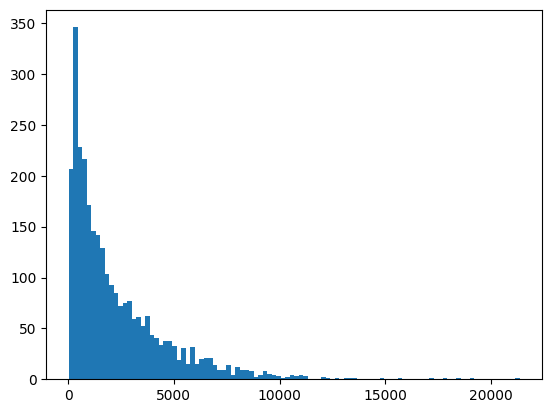

In [ ]:
# 统计contexts的总长度
context_len = []
for d in data:
    context_len.append(sum(len(c) for c in d['contexts']))
print(np.mean(context_len), np.std(context_len))
# 可视化context长度

plt.hist(context_len, bins=100)
plt.show()


2187.3518151815183 2305.8397414368965


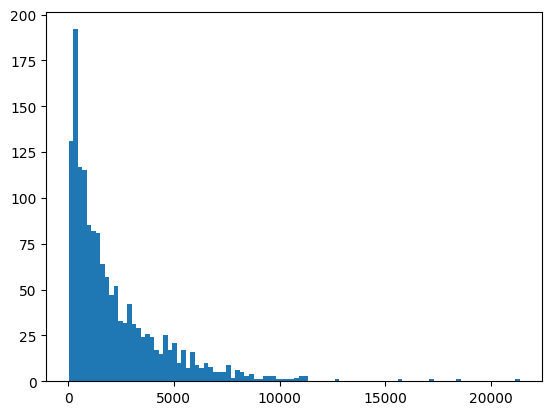

In [13]:
# 统计factoid类型contexts的总长度
context_len = []
for d in data:
    if d["type"] == "factoid":
        context_len.append(sum(len(c) for c in d['contexts']))
print(np.mean(context_len), np.std(context_len))
# 可视化context长度

plt.hist(context_len, bins=100)
plt.show()


2389.8386145910094 2361.832319497136


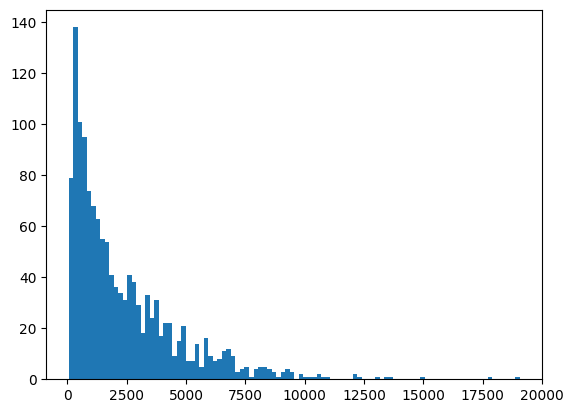

In [14]:
# 统计yesno类型contexts的总长度
context_len = []
for d in data:
    if d["type"] == "yesno":
        context_len.append(sum(len(c) for c in d['contexts']))
print(np.mean(context_len), np.std(context_len))
# 可视化context长度

plt.hist(context_len, bins=100)
plt.show()


1.1114206128133706 0.47950524492373775


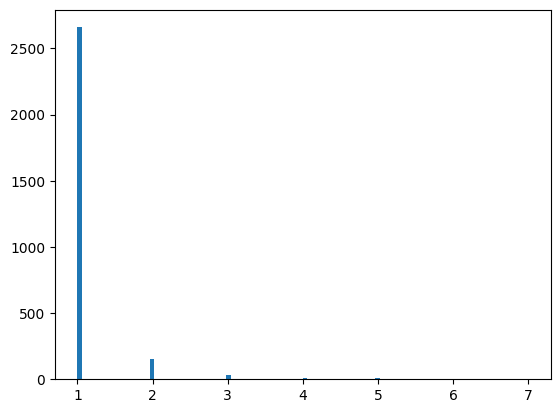

In [ ]:
# 统计answers的个数
ans_count = []
for d in data:
    ans_count.append(len(d['answers']))
print(np.mean(ans_count), np.std(ans_count))
# 可视化answers个数
plt.hist(ans_count, bins=100)
plt.show()

599.9634401114206 595.6087149726712


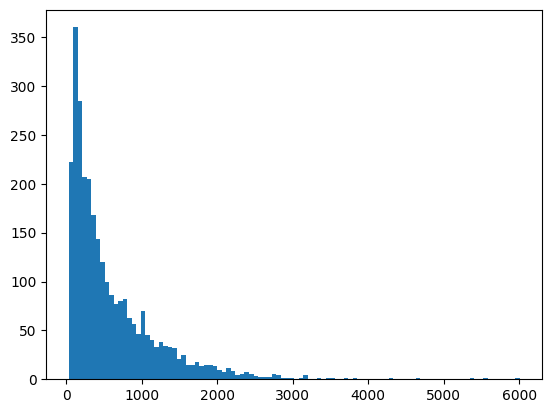

In [ ]:
# 分析prompt的token长度

def make_brief_prompt(question, context=None):
    '''构造简短回答的prompt'''
    # 简短回答的指令
    prompt = "Answer the following question as briefly as possible.\n"
    if context:
        prompt += f"Context: {context}"
    prompt += f"Question: {question}"
    prompt += f"Answer:"
    return prompt

from transformers import AutoTokenizer
model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(
                model_name, 
                # device_map="auto",
                token_type_ids=None)
token_limit = 4096


with open("dataset/original/BioASQ-training12b/training12b_process_modified.json", "r") as f:
    data = json.load(f)

token_length_list = []
for d in data:
    if d["type"] in ["factoid", "yesno"]:
        context = "\n".join([f"<context>{c}</context>" for c in d["contexts"]])
        question = d['question']
        prompt = make_brief_prompt(question, context)
        # input_data = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=token_limit)
        inputs = tokenizer(prompt, return_tensors="pt")
        token_length_list.append(inputs["input_ids"].shape[1])
print(np.mean(token_length_list), np.std(token_length_list))
plt.hist(token_length_list, bins=100)
plt.show()


In [28]:
with open("dataset/original/BioASQ-training12b/training12b_process_modified.json", "r") as f:
    data = json.load(f)

token_length_list = []
for d in data:
    if d["type"] in ["factoid", "yesno"]:
        print(d)
        context = "\n".join([f"<context>{c}</context>" for c in d["contexts"]])
        question = d['question']
        prompt = make_brief_prompt(question, context)
        print(prompt)
        break

{'question': 'Is the protein Papilin secreted?', 'id': '54e25eaaae9738404b000017', 'type': 'yesno', 'contexts': ['Using expression analysis, we identify three genes that are transcriptionally regulated by HLH-2: the protocadherin cdh-3, and two genes encoding secreted extracellular matrix proteins, mig-6/papilin and him-4/hemicentin. ', 'We found that mig-6 encodes long (MIG-6L) and short (MIG-6S) isoforms of the extracellular matrix protein papilin, each required for distinct aspects of DTC migration. Both MIG-6 isoforms have a predicted N-terminal papilin cassette', 'apilins are homologous, secreted extracellular matrix proteins which share a common order of protein domains. ', 'The TSR superfamily is a diverse family of extracellular matrix and transmembrane proteins, many of which have functions related to regulating matrix organization, cell-cell interactions and cell guidance. This review samples some of the contemporary literature regarding TSR superfamily members (e.g. F-spondi

# 构造json数据

In [32]:
# 构造json数据


def make_brief_prompt(question, context=None):
    '''构造简短回答的prompt'''
    # 简短回答的指令
    prompt = "Answer the following question as briefly as possible.\n"
    if context:
        prompt += f"Context: {context}"
    prompt += f"Question: {question}"
    prompt += f"Answer:"
    return prompt

from transformers import AutoTokenizer
model_name = "Qwen/Qwen2.5-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(
                model_name, 
                # device_map="auto",
                token_type_ids=None)
token_limit = 2048

with open("dataset/original/BioASQ-training12b/training12b_process_modified.json", "r") as f:
    data = json.load(f)

all_data = defaultdict(list)

for d in data:
    if d["type"] in ["factoid", "yesno"]:
        contexts = d["contexts"]
        context = "\n".join([f"<context>{c}</context>" for c in contexts])
        question = d['question']
        id_ = d['id']
        answers = d['answers']
        type = d['type']
        prompt = make_brief_prompt(question, context)
        inputs = tokenizer(prompt, return_tensors="pt")
        token_length = inputs["input_ids"].shape[1]
        if token_length > token_limit:
            continue
        example = {
            "id": id_,
            "context": context,
            "contexts": contexts,
            "question": question,
            "answers": answers,
            "type": type
        }
        all_data[type].append(example)
print(len(all_data["factoid"]), len(all_data["yesno"]))

1471 1314


In [34]:
def split_train_val_test(data):
    train_data = data[:1000]
    val_data = data[1000:1050]
    test_data = data[1050:1100]
    return train_data, val_data, test_data

factoid_train, factoid_val, factoid_test = split_train_val_test(all_data["factoid"])
yesno_train, yesno_val, yesno_test = split_train_val_test(all_data["yesno"])
train_data = factoid_train + yesno_train
val_data = factoid_val + yesno_val
test_data = factoid_test + yesno_test

def make_data(data):
    return {
        "id": [d["id"] for d in data],
        "data": dict((d["id"], d) for d in data),
    }

train_data = make_data(train_data)
print(len(train_data["id"]))

val_data = make_data(val_data)
print(len(val_data["id"]))

test_data = make_data(test_data)
print(len(test_data["id"]))

with open("dataset/json/bioasq_train_2000.json", "w") as f:
    json.dump(train_data, f, indent=4)

with open("dataset/json/bioasq_val_100.json", "w") as f:
    json.dump(val_data, f, indent=4)

with open("dataset/json/bioasq_test_100.json", "w") as f:
    json.dump(test_data, f, indent=4)


2000
100
100
